In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import os
os.chdir(r"C:\Users\Qing Rui\Desktop\BC3409 AI in Acc and Finance\Project\Datasets")

In [5]:
bankDef = pd.read_csv("finaldataset_1.csv")

In [47]:
bankDef = bankDef.drop(["year"], axis = 1)

In [48]:
bankDef = bankDef.drop(['exporter'], axis = 1)

In [49]:
duplicate = bankDef[bankDef.duplicated(keep = 'last')]
print("Duplicate Rows :")
# Print the resultant Dataframe
duplicate # No duplicated rows

Duplicate Rows :


,product,tradevalue,tradeshare,expgrowth,expgrowthTRIM,BANK,BANK_W3,TWIN,RZ,FL,...,CCC,RZyoung,rznoncrisis,caplab,rd,homogeneity,n,herf,intout,contcrisis


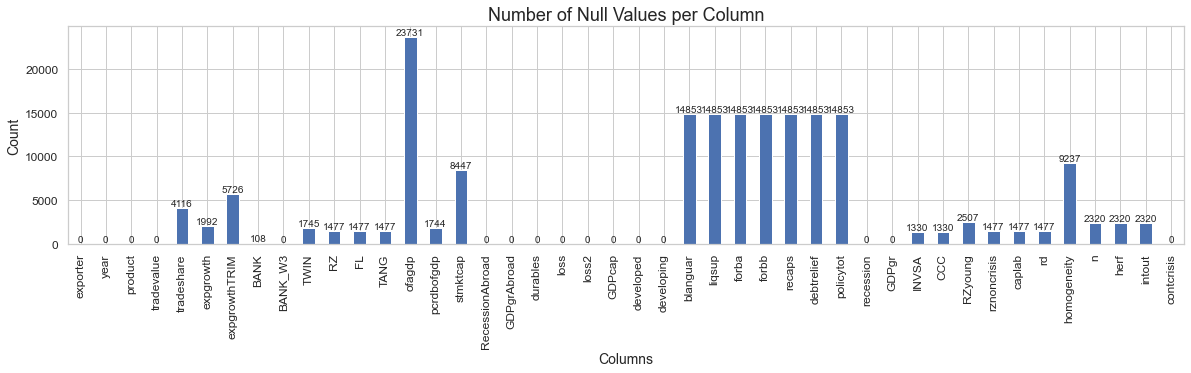

In [73]:
# Count NaN Values (https://ragvenderrawat.medium.com/miss-forest-imputaion-the-best-way-to-handle-missing-data-feature-engineering-techniques-2e6922e5cecb)

def count_nan_values(df):
    nan_counts = df.isnull().sum()
    return nan_counts

nan_counts = count_nan_values(bankDef)

# Plot the number of null values per column with counts on top of each bar
plt.figure(figsize=(20, 4))
ax = nan_counts.plot(kind='bar', fontsize=12)
plt.title('Number of Null Values per Column', fontsize=18)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Columns', fontsize=14)

# Add counts on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10)

plt.show()


In [80]:
bankDef
bankDef2 = bankDef
bankDef2 = bankDef2.drop(["year"], axis = 1)
bankDef2 = bankDef2.drop(['exporter'], axis = 1)

### Missforest algorithm to impute missing values

In [ ]:
# impute NA values using Missforest
# from missingpy import MissForest
# from sklearn.neighbors import NearestNeighbors
# import pandas as pd

# # Load your dataset with missing values
# bankDef2 = bankDef

# # Initialize the MissForest imputer
# imputer = MissForest()

# # Perform imputation
# imputed_data = imputer.fit_transform(bankDef2)

# # imputed_data now contains the dataset with missing values imputed
import statistics as stat
def add_label(data,attr,name_notnan = 'Training', name_nan = 'Predict'):
    null_pos = data[attr][data[attr].isnull()].index
    data['Label'] = name_notnan
    data['Label'].iloc[null_pos] = name_nan
    

def mean_median_imputation(data, kind = 'mean'):
    if kind=='mean':
        return data.fillna(np.mean(data.dropna()))
    elif kind == 'median': 
        return data.fillna(np.median(data.dropna()))


def mode_imputation(data):
    return data.fillna(stat.mode(data))

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

def Miss_forest_impute(data, attrb, dtype):
    train_data, test_data = data[data['Label']=='Training'], data[data['Label']=='Predict']
    
    Y = data[[attrb]]
    X = data.drop(['Label',attrb],axis = 1)
    
    y_train = train_data[[attrb]]
    x_train = train_data.drop(['Label',attrb],axis = 1)
    
    y_test = test_data[[attrb]]
    x_test = test_data.drop(['Label',attrb],axis = 1)
  
    if dtype == 'Continious':
        model = RandomForestRegressor()
        model.fit(X,Y)

    elif dtype == 'Categorical':
        model = RandomForestClassifier()
        model.fit(X,Y)
    
    y_pred = model.predict(x_test)

    return y_pred, Y[data['Label']=='Predict'].index

if 'ID' in bankDef2.columns:
    bankDef2.drop('ID',inplace = True,axis = 1)

  
data = pd.get_dummies(bankDef2)                                                  # Handling Categorical Values  
not_null_attr = data.isnull().sum()[data.isnull().sum()==0].index            # Not Null Attributes   
null_attr = data.isnull().sum()[data.isnull().sum() != 0].index              # Null Attributes  
attrbs = {}
njobs = 10

for i in null_attr: 
    df = pd.concat((data[not_null_attr], data[i]), axis = 1)
    add_label(df,i)

    if i=='CDR' or i=='MMSE':  
        df[i] = mean_median_imputation(df[[i]],kind = 'mean')

        for job in range(njobs):
            value,index = Miss_forest_impute(df,i,dtype = 'Continious')   
            df[i].iloc[index] = value
    else:
        df[i] = mode_imputation(df[i]) 

        for job in range(njobs):
            value,index = Miss_forest_impute(df,i,dtype = 'Categorical')
            df[i].iloc[index] = value

    attrbs[i] = df[i]
    

In [86]:
# https://www.analyticsvidhya.com/blog/2022/05/handling-missing-values-with-random-forest/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf
import random
import sklearn.neighbors._base 
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.impute import KNNImputer

# Create kernels.  #mice forest
kernel = mf.ImputationKernel(
  data=bankDef2,
  save_all_iterations=True,
  random_state=1343
)
# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(3,verbose=True)
#print(kernel)
completed_dataset = kernel.complete_data(dataset=0, inplace=False)  
# Miss Forest

imputer = MissForest() #miss forest
X_imputed = imputer.fit_transform(bankDef2)
X_imputed = pd.DataFrame(X_imputed, columns = bankDef2.columns).round(1)


Initialized logger with name mice 1-3
Dataset 0
1  | BANK | INVSA | CCC | FL | RZ | rznoncrisis | caplab | TANG | rd | pcrdbofgdp | TWIN | expgrowth | herf | n | intout | RZyoung | tradeshare | expgrowthTRIM | stmktcap | homogeneity | recaps | debtrelief | forbb | forba | liqsup | blanguar | policytot | ofagdp
2  | BANK | INVSA | CCC | FL | RZ | rznoncrisis | caplab | TANG | rd | pcrdbofgdp | TWIN | expgrowth | herf | n | intout | RZyoung | tradeshare | expgrowthTRIM | stmktcap | homogeneity | recaps | debtrelief | forbb | forba | liqsup | blanguar | policytot | ofagdp
3  | BANK | INVSA | CCC | FL | RZ | rznoncrisis | caplab | TANG | rd | pcrdbofgdp | TWIN | expgrowth | herf | n | intout | RZyoung | tradeshare | expgrowthTRIM | stmktcap | homogeneity | recaps | debtrelief | forbb | forba | liqsup | blanguar | policytot | ofagdp


c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  % (self.n_estimators, len(self.estimators_))
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will 

Iteration: 0


c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  % (self.n_estimators, len(self.estimators_))
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will 

Iteration: 1


c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  % (self.n_estimators, len(self.estimators_))
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will 

Iteration: 2


c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  % (self.n_estimators, len(self.estimators_))
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will 

Iteration: 3


In [88]:
X_imputed

,product,tradevalue,tradeshare,expgrowth,expgrowthTRIM,BANK,BANK_W3,TWIN,RZ,FL,...,CCC,RZyoung,rznoncrisis,caplab,rd,homogeneity,n,herf,intout,contcrisis
0,3111.0,1095742.6,0.1,1.0,1.0,0.0,0.0,0.0,0.1,0.1,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
1,3111.0,1053351.4,0.1,-0.0,-0.0,0.0,0.0,0.0,0.1,0.1,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
2,3111.0,852470.1,0.2,-0.2,-0.2,0.0,0.0,0.0,0.1,0.1,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
3,3111.0,644636.7,0.3,-0.3,-0.3,0.0,0.0,0.0,0.1,0.1,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
4,3111.0,448148.1,0.2,-0.4,-0.4,0.0,0.0,0.0,0.1,0.1,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39583,3909.0,7635532.9,0.0,-0.0,-0.0,0.0,0.0,0.0,0.5,0.1,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0
39584,3909.0,8039190.7,0.0,0.1,0.1,0.0,0.0,0.0,0.5,0.1,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0
39585,3909.0,8715190.2,0.0,0.1,0.1,0.0,0.0,0.0,0.5,0.1,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0
39586,3909.0,9842127.9,0.0,0.1,0.1,0.0,0.0,0.0,0.5,0.1,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0


In [95]:
x1 = bankDef[['exporter', 'year']]
combined_df = pd.concat([x1, X_imputed], axis=1)
combined_df

,exporter,year,product,tradevalue,tradeshare,expgrowth,expgrowthTRIM,BANK,BANK_W3,TWIN,...,CCC,RZyoung,rznoncrisis,caplab,rd,homogeneity,n,herf,intout,contcrisis
0,ARG,1980.0,3111.0,1095742.6,0.1,1.0,1.0,0.0,0.0,0.0,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
1,ARG,1981.0,3111.0,1053351.4,0.1,-0.0,-0.0,0.0,0.0,0.0,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
2,ARG,1982.0,3111.0,852470.1,0.2,-0.2,-0.2,0.0,0.0,0.0,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
3,ARG,1983.0,3111.0,644636.7,0.3,-0.3,-0.3,0.0,0.0,0.0,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
4,ARG,1984.0,3111.0,448148.1,0.2,-0.4,-0.4,0.0,0.0,0.0,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39583,USA,2002.0,3909.0,7635532.9,0.0,-0.0,-0.0,0.0,0.0,0.0,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0
39584,USA,2003.0,3909.0,8039190.7,0.0,0.1,0.1,0.0,0.0,0.0,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0
39585,USA,2004.0,3909.0,8715190.2,0.0,0.1,0.1,0.0,0.0,0.0,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0
39586,USA,2005.0,3909.0,9842127.9,0.0,0.1,0.1,0.0,0.0,0.0,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0


In [96]:
combined_df.to_csv('imputed.csv', index=False)

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir(r"C:\Users\Qing Rui\Desktop\BC3409 AI in Acc and Finance\Project\Datasets")

### SMOTE for sampling values = 1

In [7]:
df = pd.read_csv("imputed.csv")

In [8]:
# df = df.drop(["year"], axis = 1)
df = df.drop(["exporter"], axis = 1)

In [9]:
years_to_subset = [1995, 1994, 1982, 1991, 1992, 1989, 1987, 1988]
df = df[df['year'].isin(years_to_subset)]

In [10]:
df = df.drop(["year"], axis = 1)

In [11]:
df

,product,tradevalue,tradeshare,expgrowth,expgrowthTRIM,BANK,BANK_W3,TWIN,RZ,FL,...,CCC,RZyoung,rznoncrisis,caplab,rd,homogeneity,n,herf,intout,contcrisis
2,3111.0,852470.1,0.2,-0.2,-0.2,0.0,0.0,0.0,0.1,0.1,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
7,3111.0,634149.1,0.1,0.2,0.2,0.0,0.0,0.0,0.1,0.1,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
8,3111.0,645371.7,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
9,3111.0,756139.6,0.2,0.2,0.2,1.0,0.0,1.0,0.1,0.1,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
11,3111.0,931777.4,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,...,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39570,3909.0,4018655.8,0.0,0.3,0.3,0.0,0.0,0.0,0.5,0.1,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0
39572,3909.0,6269466.0,0.0,0.1,0.1,0.0,0.0,0.0,0.5,0.1,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0
39573,3909.0,7293935.7,0.0,0.2,0.2,0.0,0.0,0.0,0.5,0.1,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0
39575,3909.0,8864840.7,0.0,0.1,0.1,0.0,0.0,0.0,0.5,0.1,...,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0,0.0


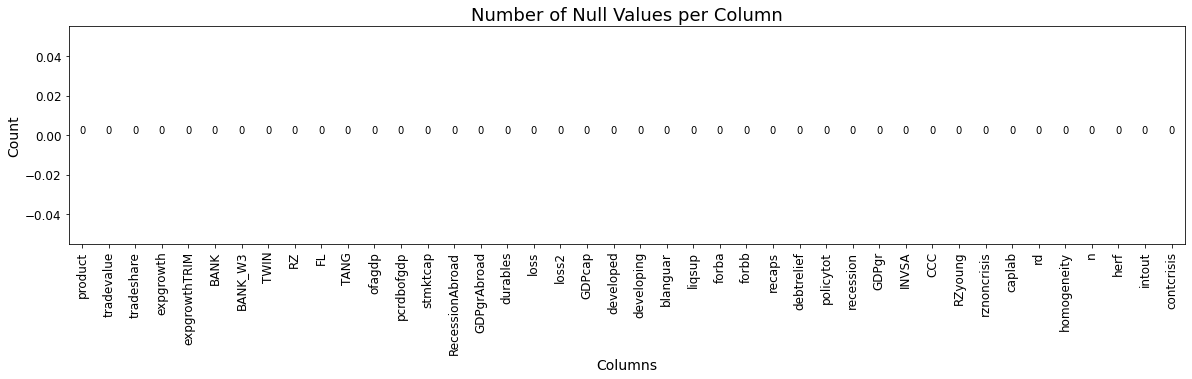

In [12]:
# Count NaN Values (https://ragvenderrawat.medium.com/miss-forest-imputaion-the-best-way-to-handle-missing-data-feature-engineering-techniques-2e6922e5cecb)

def count_nan_values(df):
    nan_counts = df.isnull().sum()
    return nan_counts

nan_counts = count_nan_values(df)

# Plot the number of null values per column with counts on top of each bar
plt.figure(figsize=(20, 4))
ax = nan_counts.plot(kind='bar', fontsize=12)
plt.title('Number of Null Values per Column', fontsize=18)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Columns', fontsize=14)

# Add counts on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10)

plt.show()

# No null values

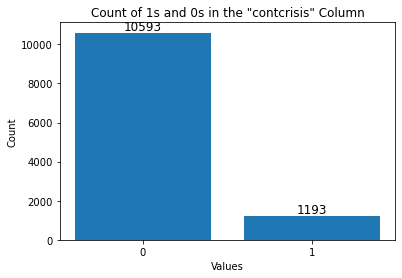

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the occurrences of '1' and '0' in the 'contcrisis' column
value_counts = df['BANK'].value_counts()

# Create a bar plot
plt.bar(value_counts.index, value_counts.values)

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Count of 1s and 0s in the "contcrisis" Column')

# Add annotations for each bar (optional)
for i, count in enumerate(value_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

# Show the plot
plt.xticks(value_counts.index, ['0', '1'])  # Optional: Set the x-axis labels
plt.show()


In [14]:
# SMOTE Values = 1 for contcrisis

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# Separate features and target
X = df.loc[:, df.columns != 'contcrisis']
y = df.loc[:, df.columns == 'contcrisis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3409)


In [15]:
X

,product,tradevalue,tradeshare,expgrowth,expgrowthTRIM,BANK,BANK_W3,TWIN,RZ,FL,...,INVSA,CCC,RZyoung,rznoncrisis,caplab,rd,homogeneity,n,herf,intout
2,3111.0,852470.1,0.2,-0.2,-0.2,0.0,0.0,0.0,0.1,0.1,...,0.1,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2
7,3111.0,634149.1,0.1,0.2,0.2,0.0,0.0,0.0,0.1,0.1,...,0.1,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2
8,3111.0,645371.7,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,...,0.1,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2
9,3111.0,756139.6,0.2,0.2,0.2,1.0,0.0,1.0,0.1,0.1,...,0.1,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2
11,3111.0,931777.4,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,...,0.1,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39570,3909.0,4018655.8,0.0,0.3,0.3,0.0,0.0,0.0,0.5,0.1,...,0.2,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0
39572,3909.0,6269466.0,0.0,0.1,0.1,0.0,0.0,0.0,0.5,0.1,...,0.2,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0
39573,3909.0,7293935.7,0.0,0.2,0.2,0.0,0.0,0.0,0.5,0.1,...,0.2,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0
39575,3909.0,8864840.7,0.0,0.1,0.1,0.0,0.0,0.0,0.5,0.1,...,0.2,1.4,0.8,0.3,14.5,0.0,0.0,1.3,0.4,1.0


In [16]:
# Apply SMOTE to the training set
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Apply SMOTE to balance the dataset
ros = RandomOverSampler(sampling_strategy="not majority", random_state=3409)
X, y = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({'contcrisis': 1})


In [17]:
from imblearn.over_sampling import SMOTE
X = df.loc[:, df.columns != 'contcrisis']
y = df.loc[:, df.columns == 'contcrisis']


# Instantiate the SMOTE resampling method
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Fit and apply SMOTE to generate synthetic samples
X_resampled, y_resampled = smote.fit_resample(X, y)

AttributeError: 'NoneType' object has no attribute 'split'

In [181]:
X

,product,tradevalue,tradeshare,expgrowth,expgrowthTRIM,BANK,BANK_W3,TWIN,RZ,FL,...,INVSA,CCC,RZyoung,rznoncrisis,caplab,rd,homogeneity,n,herf,intout
0,3111.0,1095742.6,0.1,1.0,1.0,0.0,0.0,0.0,0.1,0.1,...,0.1,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2
1,3111.0,1053351.4,0.1,-0.0,-0.0,0.0,0.0,0.0,0.1,0.1,...,0.1,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2
2,3111.0,852470.1,0.2,-0.2,-0.2,0.0,0.0,0.0,0.1,0.1,...,0.1,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2
3,3111.0,644636.7,0.3,-0.3,-0.3,0.0,0.0,0.0,0.1,0.1,...,0.1,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2
4,3111.0,448148.1,0.2,-0.4,-0.4,0.0,0.0,0.0,0.1,0.1,...,0.1,0.4,0.7,0.1,25.2,0.0,0.0,1.3,0.5,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77669,3620.0,124695.4,0.0,-0.1,-0.1,1.0,1.0,1.0,0.5,0.1,...,0.2,1.0,1.5,0.0,30.0,0.0,0.0,0.7,0.7,0.8
77670,3420.0,562.1,0.0,-0.0,-0.0,1.0,1.0,1.0,0.2,0.1,...,0.1,0.8,0.6,-0.0,18.2,0.0,0.0,0.9,0.9,0.8
77671,3232.0,15.7,0.0,0.2,0.2,1.0,1.0,1.0,-0.1,0.1,...,0.1,0.7,-1.5,-0.1,8.2,0.0,0.0,0.5,1.4,1.1
77672,3851.0,882.5,0.0,0.6,0.6,1.0,1.0,1.0,1.0,0.1,...,0.2,1.7,1.6,0.3,18.3,0.1,0.0,1.3,0.4,0.7


In [26]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [92]:
X = df.loc[:, df.columns != 'contcrisis']
y = df.loc[:, df.columns == 'contcrisis']
# from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3409)
columns = X_train.columns
columns

Index(['product', 'tradevalue', 'tradeshare', 'expgrowth', 'expgrowthTRIM',
       'BANK', 'BANK_W3', 'TWIN', 'RZ', 'FL', 'TANG', 'ofagdp', 'pcrdbofgdp',
       'stmktcap', 'RecessionAbroad', 'GDPgrAbroad', 'durables', 'loss',
       'loss2', 'GDPcap', 'developed', 'developing', 'blanguar', 'liqsup',
       'forba', 'forbb', 'recaps', 'debtrelief', 'policytot', 'recession',
       'GDPgr', 'INVSA', 'CCC', 'RZyoung', 'rznoncrisis', 'caplab', 'rd',
       'homogeneity', 'n', 'herf', 'intout'],
      dtype='object')

In [28]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

c:\Users\Qing Rui\anaconda3.1\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [87]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
logreg = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3409)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      3189
         1.0       0.00      0.00      0.00       347

    accuracy                           0.90      3536
   macro avg       0.45      0.50      0.47      3536
weighted avg       0.81      0.90      0.86      3536



c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


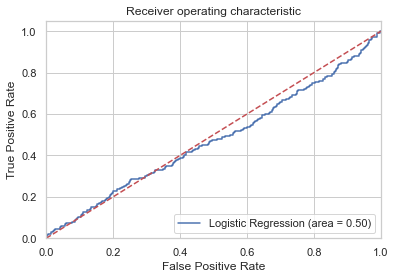

In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [50]:
# Get the coefficients (importance scores) for each feature
coefficients = logreg.coef_[0]

# Create a DataFrame with feature names and their coefficients
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitude (absolute value)
feature_importance_df['Absolute_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Print or display the sorted DataFrame
print(feature_importance_df)

            Feature   Coefficient  Absolute_Coefficient
0           product -7.662804e-04          7.662804e-04
35           caplab -6.422851e-06          6.422851e-06
19           GDPcap  3.785783e-06          3.785783e-06
30            GDPgr -1.266304e-06          1.266304e-06
15      GDPgrAbroad -5.322880e-07          5.322880e-07
38                n -2.497657e-07          2.497657e-07
32              CCC -2.266083e-07          2.266083e-07
40           intout -2.239127e-07          2.239127e-07
39             herf -1.745618e-07          1.745618e-07
28        policytot  1.659743e-07          1.659743e-07
33          RZyoung -1.469774e-07          1.469774e-07
16         durables -1.002055e-07          1.002055e-07
13         stmktcap -6.901919e-08          6.901919e-08
12       pcrdbofgdp -6.729867e-08          6.729867e-08
10             TANG -6.716255e-08          6.716255e-08
8                RZ -6.675262e-08          6.675262e-08
5              BANK  5.496392e-08          5.496

In [51]:
# https://www.geeksforgeeks.org/stepwise-regression-in-python/

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector


# Perform stepwise regression
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features=3,
                                forward=True,
                                scoring='accuracy',
                                cv=None)

selected_features = sfs.fit(X_train, y_train)
selected_features

c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=(3, 3), scoring='accuracy')

In [ ]:
selected_columns = selected_features.k_feature_names_
selected_columns

In [23]:
from sklearn import linear_model
df_selected = df[['product', 'tradeshare', 'policytot', 'recession', 'liqsup', 'GDPgr']]
 
# Split the data into train and test sets
X_train1, X_test1,\
    y_train1, y_test1 = train_test_split(
        df_selected, y,
        test_size=0.3,
        random_state=3409)
 
# Fit a logistic regression model using the selected features
logreg = linear_model.LogisticRegression()
logreg.fit(X_train1, y_train1)
 
# Make predictions using the test set
y_pred = logreg.predict(X_test1)
 
# Evaluate the model performance
print(y_pred)

[0. 0. 0. ... 0. 0. 0.]


c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      3335
         1.0       1.00      0.76      0.86       201

    accuracy                           0.99      3536
   macro avg       0.99      0.88      0.93      3536
weighted avg       0.99      0.99      0.99      3536



### Random Forest

In [25]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [32]:
# https://www.datacamp.com/tutorial/random-forests-classifier-python
rf = RandomForestClassifier()
rf.fit(X_train1, y_train1)
y_pred = rf.predict(X_test1)
accuracy = accuracy_score(y_test1, y_pred)
print("Accuracy:", accuracy)

c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9915158371040724


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3335
         1.0       0.94      0.91      0.92       201

    accuracy                           0.99      3536
   macro avg       0.97      0.95      0.96      3536
weighted avg       0.99      0.99      0.99      3536



In [31]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to pair feature names and their importance
feature_importance_df = pd.DataFrame({'Feature': X_train1.columns, 'Importance': feature_importances})

# Sort the DataFrame by feature importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
print(feature_importance_df)

      Feature  Importance
2   policytot    0.538538
5       GDPgr    0.225195
4      liqsup    0.184051
0     product    0.039949
3   recession    0.009151
1  tradeshare    0.003116


In [27]:
import pandas as pd

# Create a DataFrame with the same column names
new_data = pd.DataFrame({
    'product': [10000],      # Replace value1 with the actual value for 'product'
    'tradeshare': [10000],   # Replace value2 with the actual value for 'tradeshare'
    'policytot': [1],    # Replace value3 with the actual value for 'policytot'
    'recession': [1],    # Replace value4 with the actual value for 'recession'
    'liqsup': [1],       # Replace value5 with the actual value for 'liqsup'
    'GDPgr': [2]         # Replace value6 with the actual value for 'GDPgr'
})

predictions = rf.predict(new_data)
print(predictions)

[1.]


In [83]:
import pickle

filename = 'bankDefault_randomForest.pkl'
pickle.dump(rf, open(filename, 'wb'))

In [113]:
product = input("GDP Export of a country (Please enter a numerical value): ")
tradeshare = input("Book Value of company (Please enter a numerical value): ")
CET1Ratio = input("Please enter Capital Adequacy Tier 1 ratio of the bank (Please enter a numerical value): ")
recession = input("Enter probability of recession (Please enter a numerical value): ")
liqsup = input("Please enter Quick Ratio of the Bank (Please enter a numerical value): ")
GDPgr = input("Enterforecasted GDP Growth of the country for the year (Please enter a numerical value): ")

# Get the current working directory
current_directory = os.getcwd()

# Specify the filename (e.g., 'model.pkl') you want to unpickle
filename = 'bankDefault_randomForest.pkl'

# Construct the full file path
file_path = os.path.join(current_directory, filename)

with open(file_path, 'rb') as file:
    rf = pickle.load(file)

new_data = pd.DataFrame({
'product': [float(product)],         #  value for 'product'
'tradeshare': [float(tradeshare)],   # value for 'tradeshare'
'policytot': [float(CET1Ratio)],     # value for 'policytot'
'recession': [float(recession)],     # value for 'recession'
'liqsup': [float(liqsup)],           # value for 'liqsup'
'GDPgr': [float(GDPgr)]              # value for 'GDPgr'
})


predictions = rf.predict(new_data)

preds = "Bank Default predicted" if predictions == 1 else "No Bank Default predicted"

print(preds)

Bank Default predicted


In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      3300
         1.0       0.05      0.04      0.04       236

    accuracy                           0.88      3536
   macro avg       0.49      0.49      0.49      3536
weighted avg       0.87      0.88      0.88      3536



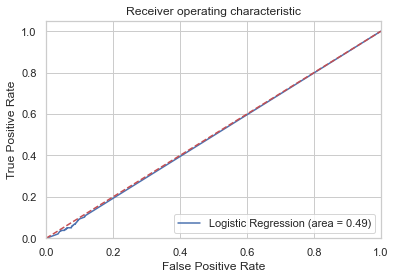

In [77]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test1))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('rf_ROC')
plt.show()

### Neural network

In [58]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

# Standardize the features (optional but recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# # Create a Keras sequential model
# model = Sequential()

# # Add the input layer
# model.add(Dense(units=len(X_train), input_dim=len(X_train), activation='relu'))

# # Add the first hidden layer (similar neurons to the input layer)
# model.add(Dense(units=len(X_train), activation='relu'))

# # Add an optional second hidden layer (you can uncomment this line if needed)
# # model.add(Dense(units=number_of_neurons, activation='relu'))

# # Add the output layer
# model.add(Dense(units=1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Print a summary of the model's architecture
# model.summary()

# # Train the model
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# Create a Keras sequential model
model = Sequential()

# Add the input layer with the correct number of neurons
input_neurons = X_train.shape[1]
model.add(Dense(units=input_neurons, input_dim=input_neurons, activation='relu'))

# Add the first hidden layer (similar neurons to the input layer)
model.add(Dense(units=input_neurons, activation='relu'))

# Add the output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41)                1722      
                                                                 
 dense_1 (Dense)             (None, 41)                1722      
                                                                 
 dense_2 (Dense)             (None, 1)                 42        
                                                                 
Total params: 3,486
Trainable params: 3,486
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
258/258 [==============================] - 2s 3ms/step - loss: 0.1373 - accuracy: 0.9550
Epoch 2/10
258/258 [==============================] - 1s 3ms/step - loss: 0.0241 - accuracy: 0.9904
Epoch 3/10
258/258 [==============================] - 1s 3ms/step - loss: 0.0148 - accuracy: 0.9949
Epoch 4/10
258/258

In [59]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)

# Threshold the predicted probabilities for binary predictions
binary_predictions = (predictions > 0.5).astype(int)

# Evaluate the binary predictions using appropriate classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(classification_report(y_test, y_pred))

111/111 [==============================] - 0s 2ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3335
         1.0       1.00      1.00      1.00       201

    accuracy                           1.00      3536
   macro avg       1.00      1.00      1.00      3536
weighted avg       1.00      1.00      1.00      3536



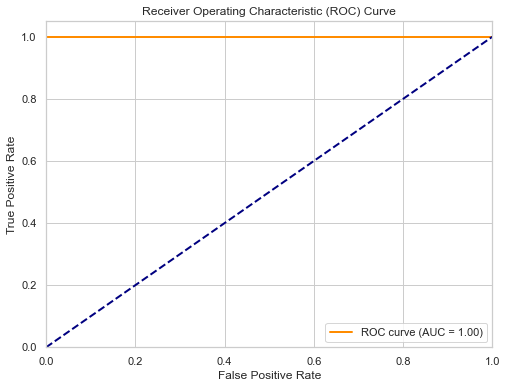

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### SVM Classifer

In [224]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)


c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [ ]:
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, clf.decision_function(X_test))

# Calculate the AUC
auc = roc_auc_score(y_test, clf.decision_function(X_test))

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### KNN classification

In [57]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features (recommended for KNN)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Create a KNN classifier
k = 2  # Number of neighbors
classifier = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)

# Train the classifier on the training data
classifier.fit(X_train_std, y_train)

# Predict the labels for the test data
y_pred = classifier.predict(X_test_std)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


AttributeError: 'NoneType' object has no attribute 'split'

In [55]:
y_pred= classifier.predict(X_test)

c:\Users\Qing Rui\anaconda3.1\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [32]:
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')


AttributeError: 'NoneType' object has no attribute 'split'